In [1]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils

In [2]:
img = cv2.imread('HOG/test/20171118_130335.jpg')
#20171118_130327.jpg')
#20171118_133018.jpg')
#20171118_130337.jpg')
#20171118_130340.jpg')
#20171118_130335.jpg') 
#test.jpg
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

(<matplotlib.axes._subplots.AxesSubplot at 0x2a78fa1d630>,
 <matplotlib.text.Text at 0x2a78fa1db70>)

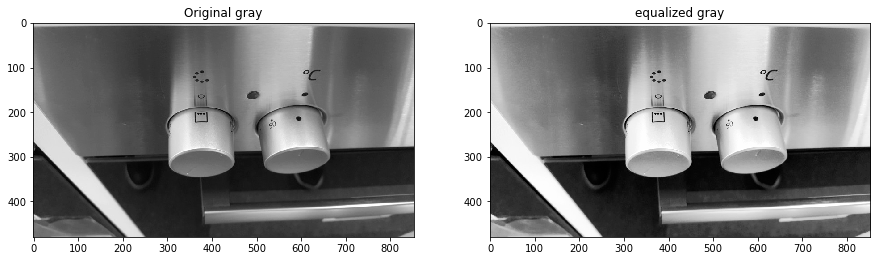

In [3]:
# histogram equalization with open cv
# with open cv: cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])
#hist = cv2.calcHist([img],[0],None,[256],[0,256])
gray_eq = cv2.equalizeHist(gray)

plt.figure(figsize = (15,10))
plt.subplot(1,2,1), plt.imshow(gray,cmap = 'gray'), plt.title('Original gray')
plt.subplot(1,2,2), plt.imshow(gray_eq,cmap = 'gray'), plt.title('equalized gray')

(<matplotlib.axes._subplots.AxesSubplot at 0x2a78fac3630>,
 <matplotlib.text.Text at 0x2a78fd4a080>)

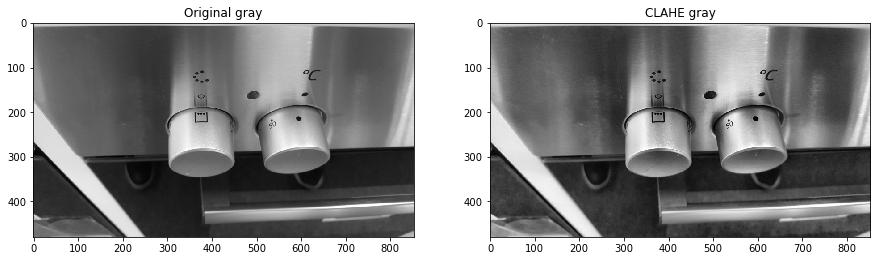

In [4]:
# CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_cl = clahe.apply(gray)

plt.figure(figsize = (15,10))
plt.subplot(1,2,1), plt.imshow(gray,cmap = 'gray'), plt.title('Original gray')
plt.subplot(1,2,2), plt.imshow(gray_cl,cmap = 'gray'), plt.title('CLAHE gray')

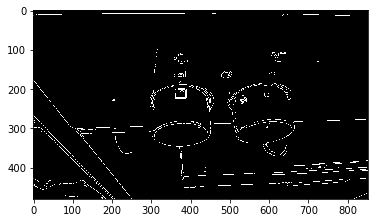

In [5]:
# cv2.Canny(image, threshold1, threshold2[, edges[, apertureSize[, L2gradient]]]) → edges

#edges = cv2.Canny(gray, 30, 90 , apertureSize = 3)
#edges = imutils.auto_canny(gray)
edges = imutils.auto_canny(gray_eq)
#edges = imutils.auto_canny(gray_cl)
#edges = cv2.Canny(gray, fthird, sthird , apertureSize = 3)

plt.imshow(edges, cmap="gray")
# best result => gray equalizaiton

In [6]:
# Fourth argument is threshold, which means minimum vote it should get for it to be considered as a line. 
# Remember, number of votes depend upon number of points on the line. 
# So it represents the minimum length of line that should be detected.
# threshold: 15% of width
threshold = round(gray.shape[1] * 0.15)

lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)

type(lines)
if lines is None:
    print('CAUTION: no lines detected')
else:
    print('amount of line elements: ', len(lines),',threshold: ', threshold, 'width of img: ', gray.shape[1])

# alternative: Probabilistic Hough Transform  (cv2.HoughLinesP)

amount of line elements:  18 ,threshold:  128 width of img:  853


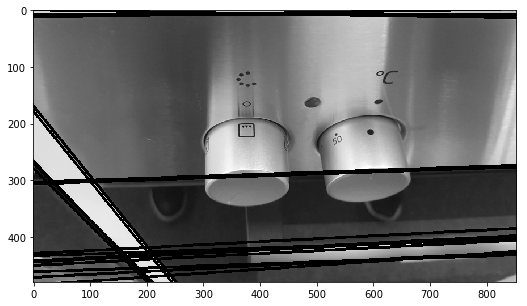

In [7]:
params = {}
c = 0

for i in range(len(lines)):    
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    cv2.line(gray,(x1,y1),(x2,y2),(0,0,255),3)
    params[c] = { 'rho': rho, 'theta': theta } 
    c += 1

plt.figure(figsize = (10,5))
plt.imshow(gray, cmap="gray")

In [21]:
from helper import *

from importlib import reload
#reload(helper)

#import importlib
#importlib.reload(helper)

NameError: name 'helper' is not defined

In [23]:
lines = fetchLineCoordinates(gray.shape[0], gray.shape[1], params)

top_line = extractTopLine(gray.shape[0], gray.shape[1], lines['hori'])
bot_line = extractBottomLine(gray.shape[0], gray.shape[1], lines['hori'])

left_line = extractLeftLine(gray.shape[0], gray.shape[1], lines['vert'])
right_line = extractRightLine(gray.shape[0], gray.shape[1], lines['vert'])

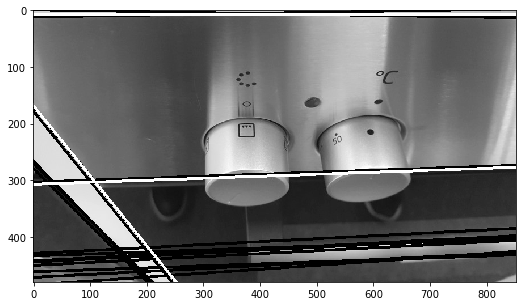

In [17]:
cv2.line(gray, left_line[0], left_line[1], (255,255,255), 3)
cv2.line(gray, right_line[0], right_line[1], (255,255,255), 3)
cv2.line(gray, top_line[0], top_line[1], (255,255,255), 3)
cv2.line(gray, bot_line[0], bot_line[1], (255,255,255), 3)

plt.figure(figsize = (10,5))
plt.imshow(gray, cmap = "gray")

In [31]:
#  http://nessy.info/?p=16

def extractPolygonPoints(t_line, b_line, l_line, r_line, M, N):
    #pts = []
    pts = {}
    poly = []
    
    top_line = Line(t_line)
    bottom_line = Line(b_line)
    left_line = Line(l_line)
    right_line = Line(r_line)
    
    l_slope = {"top": top_line.slope() if top_line.slope() is not None else np.nan, 
               "bottom": bottom_line.slope() if bottom_line.slope() is not None else np.nan,
               "right": right_line.slope() if right_line.slope() is not None else np.nan,
               "left": left_line.slope() if left_line.slope() is not None else np.nan}
    l_yintersept = {"top": top_line.yintercept(l_slope["top"]) if l_slope["top"] is not None else np.nan, 
                    "bottom": bottom_line.yintercept(l_slope["bottom"]) if l_slope["bottom"] is not None else np.nan, 
                    "right": right_line.yintercept(l_slope["right"]) if l_slope["right"] is not None else np.nan, 
                    "left": left_line.yintercept(l_slope["left"]) if l_slope["left"] is not None else np.nan}
    
    #print('slope: ',l_slope)
    #print('yintersept',l_yintersept)
    #print(list(l_slope.values()))
    
    pts["left"]={}
    pts["right"]={}
    pts["top"]={}
    pts["bottom"]={}
    
    # first step: calculate points on image borders
    
    # left line
    # if left line vertical
    if l_line[0][0] == l_line[1][0]:
        #pts.append(l_line[0])
        #pts.append(_line[1])
        pts["left"]["0"] = l_line[0]
        pts["left"]["1"] = l_line[1]
    else:
        if 0 < l_line[0][0] < N:
            #pts.append(l_line[0])
            pts["left"]["0"] = l_line[0]
        else:
            #print(l_yintersept["left"])
            #pts.append((0, int(l_yintersept["left"])))
            pts["left"]["0"] = (0, int(l_yintersept["left"]))

        if 0 < l_line[1][0] < N:
            #pts.append(l_line[1])
            pts["left"]["1"] = l_line[1]
        else:
            #pts.append((0, int(l_yintersept["left"])))
            pts["left"]["1"] = (0, int(l_yintersept["left"]))
     
        
    # right line
    # if right line vertical
    if r_line[0][0] == r_line[1][0]:
        #pts.append(r_line[0])
        #pts.append(r_line[1])
        pts["right"]["0"] = r_line[0]
        pts["right"]["1"] = r_line[1]
    else:        
        if 0 < r_line[0][0] < N:
            #pts.append(r_line[0])
            pts["right"]["0"] = r_line[0]
        else:
            #pts.append((0, int(right_line.solve_for_y(N, l_slope["right"], l_yintersept["right"]))))
            pts["right"]["0"] = (N, int(right_line.solve_for_y(N, l_slope["right"], l_yintersept["right"])))
            # stimmt die 0 hier?? =N

        if 0 < r_line[1][0] < N:
            #pts.append(r_line[1])
            pts["right"]["1"] = r_line[1]
        else:
            #pts.append((0, int(right_line.solve_for_y(N, l_slope["right"], l_yintersept["right"]))))
            pts["right"]["1"] = (N, int(right_line.solve_for_y(N, l_slope["right"], l_yintersept["right"])))
            # stimmt die 0 hier?? =N
     
    # top line
    # if top line horizontal
    if t_line[0][1] == t_line[1][1]:
        #pts.append(t_line[0])
        #pts.append(t_line[1])
        pts["top"]["0"] = t_line[0]
        pts["top"]["1"] = t_line[1]
    else:        
        if 0 < t_line[0][1] < M:
            #pts.append(t_line[0])
            pts["top"]["0"] = t_line[0]
        else:
            #pts.append((int(top_line.solve_for_x(0, l_slope["top"], l_yintersept["top"])), 0))
            pts["top"]["0"] = (int(top_line.solve_for_x(0, l_slope["top"], l_yintersept["top"])), 0)

        if 0 < t_line[1][1] < M:
            #pts.append(t_line[1])
            pts["top"]["1"] = t_line[1]
        else:
            #pts.append((int(top_line.solve_for_x(0, l_slope["top"], l_yintersept["top"])), 0))
            pts["top"]["1"] = (int(top_line.solve_for_x(0, l_slope["top"], l_yintersept["top"])), 0)

    # bottom line
    # if bottom line horizontal
    
    #print("Bottom line:")
    #print(b_line)
    if b_line[0][1] == b_line[1][1]:
        #pts.append(b_line[0])
        #pts.append(b_line[1])
        pts["bottom"]["0"] = b_line[0]
        pts["bottom"]["1"] = b_line[1]
    else:        
        if 0 <= b_line[0][1] <= M:
            pts["bottom"]["0"] = b_line[0]
        else:
            pts["bottom"]["0"] = (int(bottom_line.solve_for_x(M, l_slope["bottom"], l_yintersept["bottom"])), M)

        if 0 <= b_line[1][1] <= M:
            pts["bottom"]["1"] = b_line[1]
        else:
            pts["bottom"]["1"] = (int(bottom_line.solve_for_x(M, l_slope["bottom"], l_yintersept["bottom"])), M)
           
        
    print('Step 1: Punkte auf dem Rand')
    print(list(pts.values()))
    
    # # step 2: calculate intersections between neighboring lines (tr, rb, bl, lt)
    intersect_x = {"tr": int(-(l_yintersept["top"] - l_yintersept["right"])/(l_slope["top"]-l_slope["right"]))
                   if l_slope["right"] is not np.nan else r_line[0][0], 
              "rb": int(-(l_yintersept["bottom"] - l_yintersept["right"])/(l_slope["bottom"]-l_slope["right"])) 
                   if l_slope["right"] is not np.nan else r_line[0][0],
              "bl": int(-(l_yintersept["bottom"] - l_yintersept["left"])/(l_slope["bottom"]-l_slope["left"]))
                   if l_slope["left"] is not np.nan else l_line[0][0],
              "lt": int(-(l_yintersept["top"] - l_yintersept["left"])/(l_slope["top"]-l_slope["left"]))
                  if l_slope["left"] is not np.nan else l_line[0][0]}
    # müssen hier die jeweils anderen slopes auch noch auf np.nan überprüft werden?
    intersect_y = {"tr": int(l_slope["top"]*intersect_x["tr"]+l_yintersept["top"]),
               "rb": int(l_slope["bottom"]*intersect_x["rb"]+l_yintersept["bottom"]), 
               "bl": int(l_slope["bottom"]*intersect_x["bl"]+l_yintersept["bottom"]),
               "lt": int(l_slope["top"]*intersect_x["lt"]+l_yintersept["top"]) }
    
    print('Step 2: Schnittpunkte')
    print(intersect_x)
    print(intersect_y)
    
    
    # check if intersection points are within the image
    if (0 <= intersect_x["tr"] <= N) & (0 <= intersect_y["tr"] <= M):
        #print('Nehme Schnittpkt tr')
        poly.append((intersect_x["tr"], intersect_y["tr"]))
        del pts["top"]["1"]
        del pts["right"]["0"]
    if (0 <= intersect_x["bl"] <= N) & (0 <= intersect_y["bl"] <= M):
        #print('Nehme Schnittpkt bl')
        poly.append((int(intersect_x["bl"]), int(intersect_y["bl"])))
        del pts["bottom"]["0"]
        del pts["left"]["1"]
    if (0 <= intersect_x["rb"] <= N) & (0 <= intersect_y["rb"] <= M):
        #print('Nehme Schnittpkt rb')
        #print(pts["bottom"])
        poly.append((intersect_x["rb"], intersect_y["rb"]))
        del pts["bottom"]["1"]
        del pts["right"]["1"]
    if (0 <= intersect_x["lt"] <= N) & (0 <= intersect_y["lt"] <= M):
        #print('Nehme Schnittpkt lt')
        poly.append((intersect_x["lt"], intersect_y["lt"]))
        del pts["top"]["0"]
        del pts["left"]["0"]
    
    pts = list(pts.values())

    for i in range(len(pts)): 
          if pts[i].values():
                poly.append(list(pts[i].values())[0])
             
    return poly
    
    
pts = extractPolygonPoints(top_line, bot_line, left_line, right_line, gray.shape[0], gray.shape[1])
#print(pts)

Step 1: Punkte auf dem Rand
[{'0': (0, 168), '1': (252, 480)}, {'0': (853, 0), '1': (853, 480)}, {'0': (0, 8), '1': (853, 8)}, {'0': (0, 307), '1': (853, 277)}]
Step 2: Schnittpunkte
{'tr': 853, 'rb': 853, 'bl': 109, 'lt': -129}
{'tr': 8, 'rb': 277, 'bl': 303, 'lt': 8}
[(853, 8), (109, 303), (853, 277), (0, 168), (0, 8)]


Step 1: Punkte auf dem Rand
[{'0': (0, 168), '1': (252, 480)}, {'0': (853, 0), '1': (853, 480)}, {'0': (0, 8), '1': (853, 8)}, {'0': (0, 307), '1': (853, 277)}]
Step 2: Schnittpunkte
{'tr': 853, 'rb': 853, 'bl': 109, 'lt': -129}
{'tr': 8, 'rb': 277, 'bl': 303, 'lt': 8}


(<matplotlib.axes._subplots.AxesSubplot at 0x2a78ff95048>,
 <matplotlib.text.Text at 0x2a79037bdd8>)

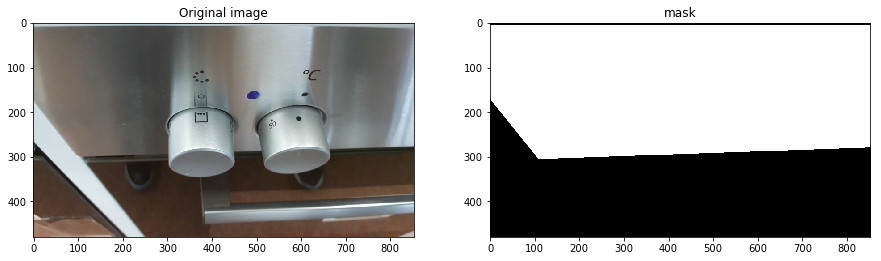

In [18]:
# execute grabCut Alg.
img_color = img.copy() #cv2.imread('HOG/test/20171118_130337.jpg') #test.jpg')
#img_color_cut = img_color[y0:y1, 0:n].copy()
mask = np.zeros(img_color.shape[:2],np.uint8)

pts = extractPolygonPoints(top_line, bot_line, left_line, right_line, gray.shape[0], gray.shape[1])
hull = cv2.convexHull(np.array(pts), clockwise = True)
cv2.polylines(mask, [hull], True, (255, 255, 255), 3)
cv2.fillPoly(mask, [hull], (255, 255, 255))

mask[mask == 0] = 0
mask[mask == 255] = 1

plt.figure(figsize = (15,10))
plt.subplot(1,2,1), plt.imshow(img_color), plt.title('Original image')
plt.subplot(1,2,2), plt.imshow(mask, cmap = 'gray'), plt.title('mask')

In [19]:
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

print('mask size: ', mask.shape)
rect = (0, y0, img.shape[1], y1) 
mask_rect = np.zeros(img_color.shape[:2],np.uint8)
print('rect, format: (x,y,w,h): ', rect)

#cv2.grabCut(img_color, mask_rect,rect,bgdModel,fgdModel, 6, cv2.GC_INIT_WITH_RECT)
cv2.grabCut(img_color, mask, None, bgdModel, fgdModel, 6, cv2.GC_INIT_WITH_MASK)
print('grabCut finished')

mask size:  (480, 853)
rect, format: (x,y,w,h):  (0, -0.99984771, 853, -18)
grabCut finished


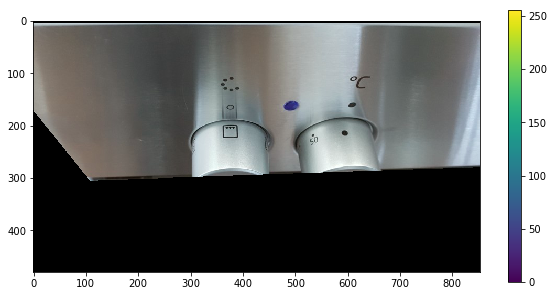

In [20]:
#mask2 = np.where((mask_rect==2)|(mask_rect==0),0,1).astype('uint8')
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img_color = img_color * mask2[:,:,np.newaxis]

plt.figure(figsize = (10,5))
plt.imshow(img_color)
plt.colorbar()
plt.show()

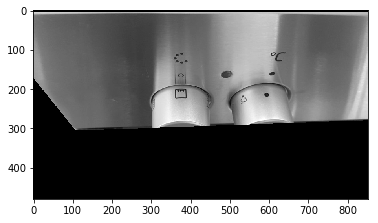

In [33]:
# führe erneute hough transformation aus um eventuelle linien der Knöpfe zu erkennen
gray_button = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY) 
#gray_button = cv2.equalizeHist(gray_button)
edges_button = imutils.auto_canny(gray_button)
#edges = cv2.Canny(gray, fthird, sthird , apertureSize = 3)

plt.imshow(image, cmap="gray")

(<matplotlib.axes._subplots.AxesSubplot at 0x1cff53fe2b0>,
 <matplotlib.text.Text at 0x1cff656f7b8>)

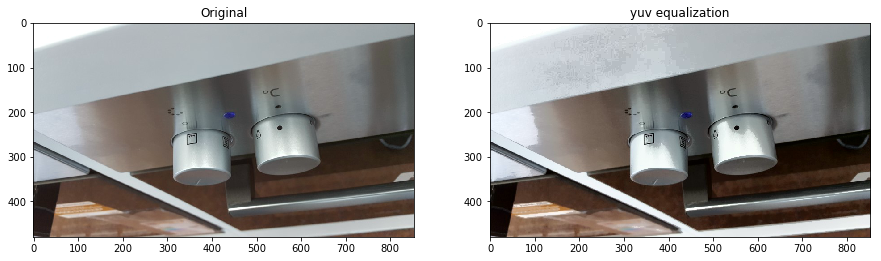

In [52]:
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) 
img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
img_eqHist = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

plt.figure(figsize = (15,10))
plt.subplot(1,2,1), plt.imshow(img), plt.title('Original')
plt.subplot(1,2,2), plt.imshow(img_eqHist), plt.title('yuv equalization')

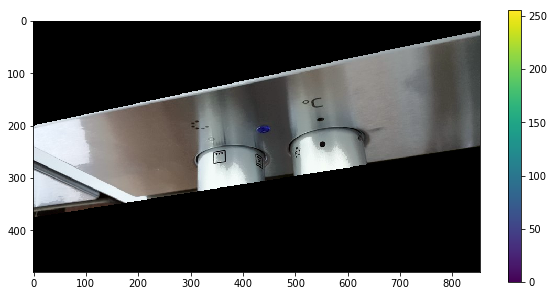

In [57]:
cv2.grabCut(img_eqHist, mask, None, bgdModel, fgdModel, 6, cv2.GC_INIT_WITH_MASK)
mask3 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img_eqHist = img_eqHist * mask3[:,:,np.newaxis]

plt.figure(figsize = (10,5))
plt.imshow(img_eqHist)
plt.colorbar()
plt.show()

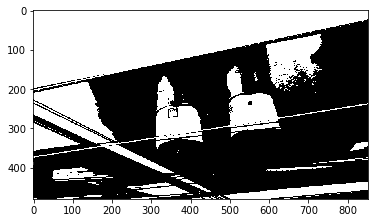

In [45]:
#im = cv2.imread("HOG/test/20171118_130335.jpg")
#imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
test = gray.copy()

ret, thresh =  cv2.threshold(gray, 127, 255, 0)#cv2.threshold(img_cut, 127, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#ret,thresh = cv2.threshold(im,127,255,0)
#contours,hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]
plt.imshow(im2, cmap= "gray")

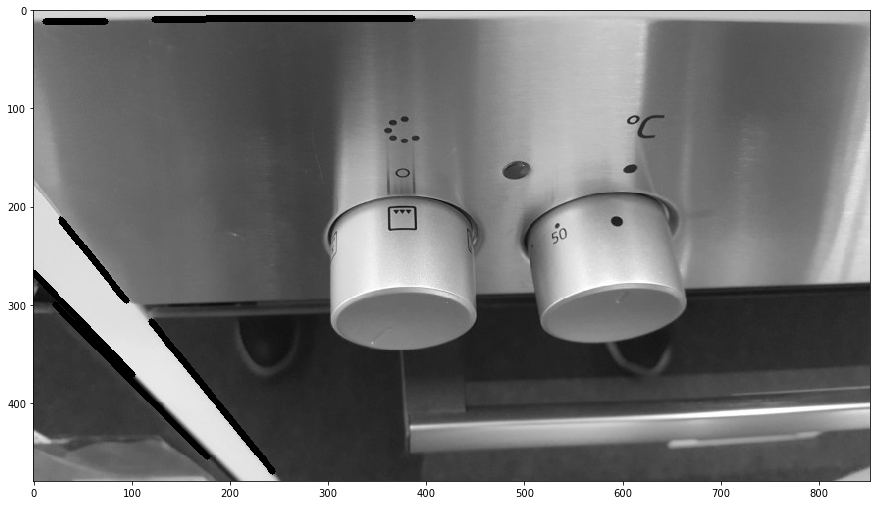

In [63]:
minLineLength = 100
maxLineGap = 50

gray_p = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)

for i in range(len(lines)):
    x1 = lines[i][0][0]
    y1 = lines[i][0][1]
    x2 = lines[i][0][2]
    y2 = lines[i][0][3]
    cv2.line(gray_p, (x1,y1),(x2,y2),(0,255,0),5)

plt.figure(figsize = (15,10))
plt.imshow(gray_p, cmap="gray")